In [1]:
# Basic data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Model imports
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

### Data Loading

In [2]:
num = pd.read_csv('rmpCapstoneNum.csv', header=None)
qual = pd.read_csv('rmpCapstoneQual.csv', header=None)
tag = pd.read_csv('rmpCapstoneTags.csv', header=None)

In [3]:
num_columns = [
    "Average Rating",            # The arithmetic mean of all individual quality ratings of this professor
    "Average Difficulty",        # The arithmetic mean of all individual difficulty ratings of this professor
    "Number of Ratings",         # Total number of ratings these averages are based on
    "Received a 'pepper'?",      # Boolean - judged as "hot" by the students
    "Proportion Retake",         # Proportion of students that said they would take the class again
    "Online Ratings Count",      # Number of ratings coming from online classes
    "Male Gender",               # Boolean – 1: determined with high confidence that professor is male
    "Female Gender"              # Boolean – 1: determined with high confidence that professor is female
]
num.columns = num_columns

In [4]:
qual_columns = [
    "Major/Field",  # Column 1: Major/Field
    "University",   # Column 2: University
    "US State"      # Column 3: US State (2-letter abbreviation)
]
qual.columns = qual_columns

In [5]:
tags_columns = [
    "Tough grader",              # Column 1
    "Good feedback",             # Column 2
    "Respected",                 # Column 3
    "Lots to read",              # Column 4
    "Participation matters",     # Column 5
    "Don't skip class",          # Column 6
    "Lots of homework",          # Column 7
    "Inspirational",             # Column 8
    "Pop quizzes!",              # Column 9
    "Accessible",                # Column 10
    "So many papers",            # Column 11
    "Clear grading",             # Column 12
    "Hilarious",                 # Column 13
    "Test heavy",                # Column 14
    "Graded by few things",      # Column 15
    "Amazing lectures",          # Column 16
    "Caring",                    # Column 17
    "Extra credit",              # Column 18
    "Group projects",            # Column 19
    "Lecture heavy"              # Column 20
]
tag.columns = tags_columns

In [6]:
num.head()

,Average Rating,Average Difficulty,Number of Ratings,Received a 'pepper'?,Proportion Retake,Online Ratings Count,Male Gender,Female Gender
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0


In [7]:
qual.head()

,Major/Field,University,US State
0,Criminal Justice,George Mason University,VA
1,NaN,NaN,NaN
2,English,Alabama State University,AL
3,English,University of Kentucky,KY
4,English,Keiser University,FL


In [8]:
tag.head()

,Tough grader,Good feedback,Respected,Lots to read,Participation matters,Don't skip class,Lots of homework,Inspirational,Pop quizzes!,Accessible,So many papers,Clear grading,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,2,1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,3,0,0,2,4,2,1,0,0,0,2,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Question 9
Build a regression model predicting average difficulty from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R2and RMSE of this model. Which of these tags is most strongly predictive of average difficulty? Hint: Make sure to address collinearity concerns

In [9]:
# Ensure the datasets have the same number of records
assert len(num) == len(qual) == len(tag), "Datasets lengths do not match."

# Merge the datasets
merged_df = pd.concat([num, qual, tag], axis=1)


In [10]:
# drop na of average rating 
merged_df = merged_df.dropna(subset=['Average Difficulty'])
merged_df.head()

,Average Rating,Average Difficulty,Number of Ratings,Received a 'pepper'?,Proportion Retake,Online Ratings Count,Male Gender,Female Gender,Major/Field,University,...,So many papers,Clear grading,Hilarious,Test heavy,Graded by few things,Amazing lectures,Caring,Extra credit,Group projects,Lecture heavy
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1,Criminal Justice,George Mason University,...,0,0,0,0,0,0,0,0,0,1
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0,English,Alabama State University,...,0,0,0,0,0,0,0,0,0,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0,English,University of Kentucky,...,0,2,1,0,0,0,0,0,1,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0,English,Keiser University,...,0,0,0,0,0,0,0,0,0,0
5,3.5,3.3,22.0,0.0,56.0,7.0,1,0,English,Eastern Florida State College,...,0,7,3,0,0,0,3,0,1,3


In [11]:
# check na
print('before cleaning NA', len(merged_df))
print(merged_df[tags_columns].isnull().sum())

before cleaning NA 70004
Tough grader             0
Good feedback            0
Respected                0
Lots to read             0
Participation matters    0
Don't skip class         0
Lots of homework         0
Inspirational            0
Pop quizzes!             0
Accessible               0
So many papers           0
Clear grading            0
Hilarious                0
Test heavy               0
Graded by few things     0
Amazing lectures         0
Caring                   0
Extra credit             0
Group projects           0
Lecture heavy            0
dtype: int64


count    70004.000000
mean         5.374721
std          8.136628
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        393.000000
Name: Number of Ratings, dtype: float64


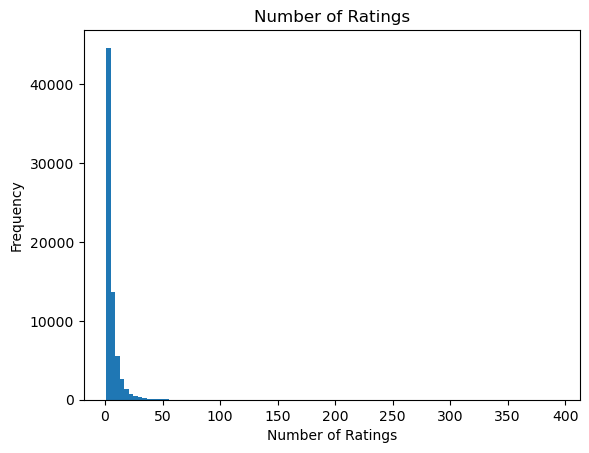

In [12]:
print(merged_df['Number of Ratings'].describe())
plt.hist(merged_df['Number of Ratings'], bins=100)
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Number of Ratings')
plt.show()

In [13]:
# set the threshold to 5 ratings and exclude the professors with less than 5 ratings
print(len(merged_df))
merged_df = merged_df[merged_df['Number of Ratings'] >= 5]
print(len(merged_df))

70004
25368


In [14]:
# For each tag column
for tag_column in tags_columns:
    # Create new normalized column
    merged_df[f'{tag_column}_normalized'] = merged_df[tag_column] / merged_df['Number of Ratings']
# create a list of normalized cols
normalized_columns = [f'{tag_column}_normalized' for tag_column in tags_columns]

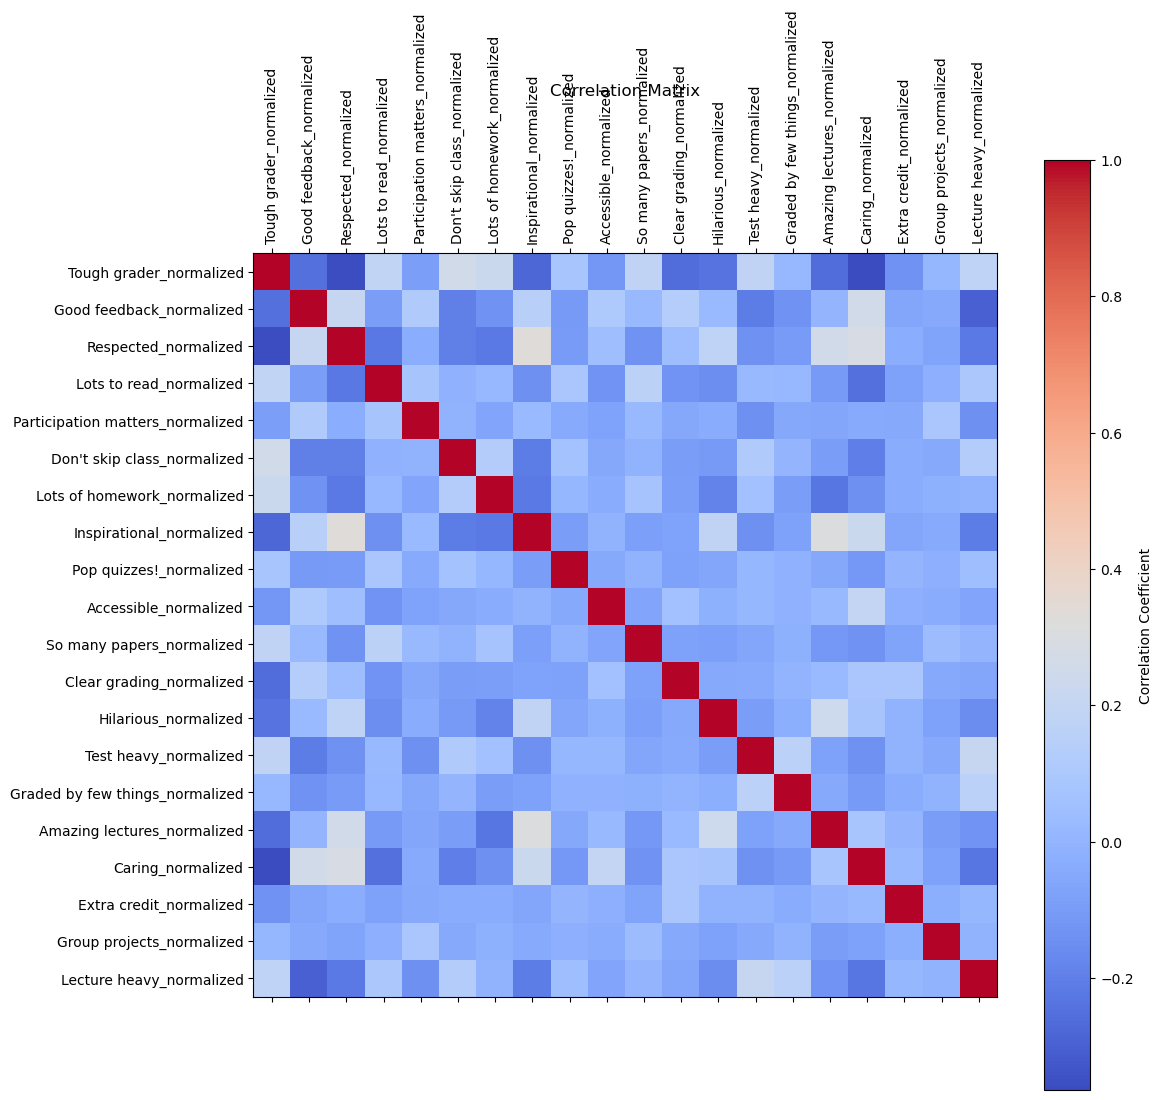

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation matrix
correlation_matrix = merged_df[normalized_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 12))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)  # Use a diverging colormap
plt.xticks(range(len(normalized_columns)), normalized_columns, rotation=90)
plt.yticks(range(len(normalized_columns)), normalized_columns)
plt.colorbar(label='Correlation Coefficient')  # Add label for clarity
plt.title('Correlation Matrix', y=1.2)  # Add title with some spacing
plt.show()

In [16]:
# 1. Prepare features
feature_columns = (
    normalized_columns
)

X = merged_df[feature_columns]
y = merged_df['Average Difficulty']

# 2. Single train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale features (fit only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Model definitions with proper parameter grids
ridge_params = {'alpha': np.logspace(-3, 4, 50)} 
lasso_params = {'alpha': np.logspace(-3, 4, 50)}

# 5. Initialize models
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)

# 6. Initialize cross-validation for training data
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 7. Train and evaluate models
models = {
    'Ridge': (ridge, ridge_params),
    'Lasso': (lasso, lasso_params),
}

results = {}
for name, (model, params) in models.items():
    # Perform GridSearchCV on training data
    grid_search = GridSearchCV(
        model, 
        params, 
        cv=kf, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Fit on training data
    grid_search.fit(X_train_scaled, y_train)
    
    # Get cross-validation results
    cv_results = {
        'CV_RMSE': np.sqrt(-grid_search.cv_results_['mean_test_score']),
        'CV_RMSE_std': np.sqrt(grid_search.cv_results_['std_test_score'])
    }
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions on test set
    y_pred = best_model.predict(X_test_scaled)
    
    # Calculate final test metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'CV_RMSE': cv_results['CV_RMSE'][grid_search.best_index_],
        'CV_RMSE_std': cv_results['CV_RMSE_std'][grid_search.best_index_],
        'Test_RMSE': test_rmse,
        'Test_R2': test_r2,
        'Best_Params': grid_search.best_params_
    }

# 8. Display results
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\nModel Performance Results:")
print("\nCross-validation results (on training data):")
print(results_df[['CV_RMSE', 'CV_RMSE_std']])
print("\nTest set results:")
print(results_df[['Test_RMSE', 'Test_R2']])

print("\nBest Parameters:")
for model_name, result in results.items():
    print(f"\n{model_name}:")
    print(result['Best_Params'])


Model Performance Results:

Cross-validation results (on training data):
        CV_RMSE  CV_RMSE_std
Ridge  0.541941     0.089317
Lasso  0.541956     0.089332

Test set results:
       Test_RMSE   Test_R2
Ridge   0.547847  0.537945
Lasso   0.547717  0.538163

Best Parameters:

Ridge:
{'alpha': 51.794746792312125}

Lasso:
{'alpha': 0.001}


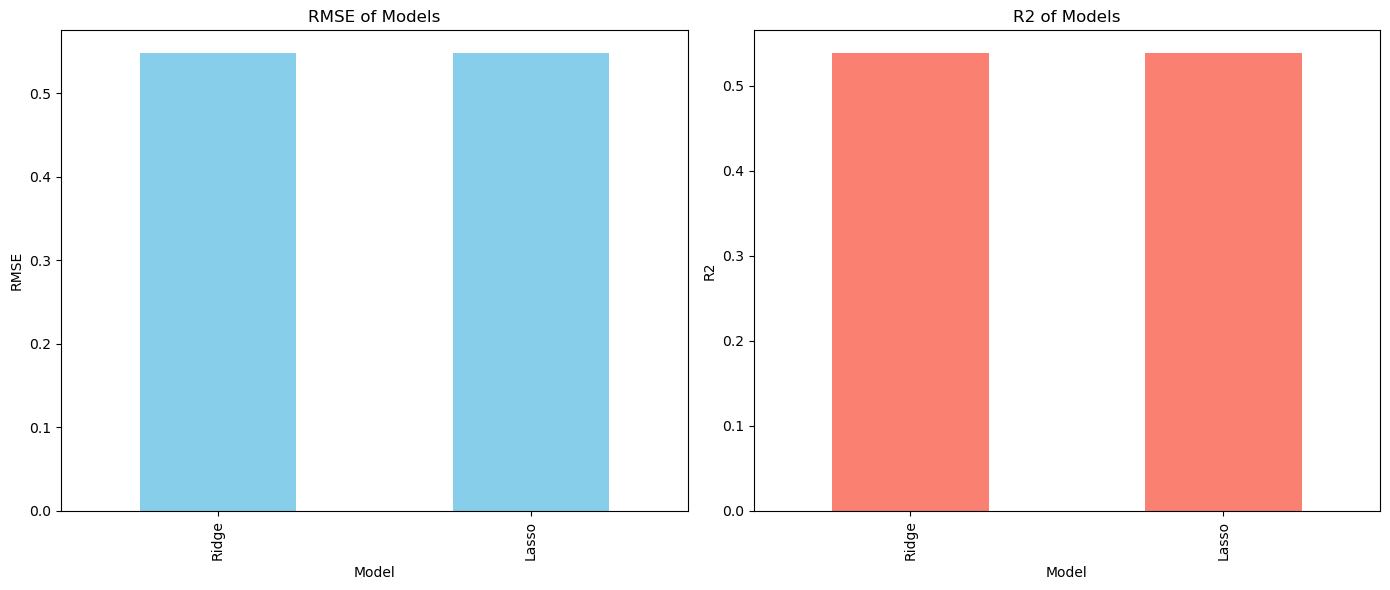

In [17]:
# create a visualization of the results
import matplotlib.pyplot as plt

# Extract RMSE and R2 values
rmse_values = results_df['Test_RMSE']
r2_values = results_df['Test_R2']

# Create a figure and axis
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot RMSE
rmse_values.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('RMSE of Models')
ax[0].set_ylabel('RMSE')
ax[0].set_xlabel('Model')

# Plot R2
r2_values.plot(kind='bar', ax=ax[1], color='salmon')
ax[1].set_title('R2 of Models')
ax[1].set_ylabel('R2')
ax[1].set_xlabel('Model')

# Display the plot
plt.tight_layout()
plt.show()


Lasso Coefficients (Sorted):
                                  Coefficient  Coefficient_abs
Tough grader_normalized              0.385222         0.385222
Test heavy_normalized                0.099191         0.099191
Accessible_normalized                0.096192         0.096192
Lots of homework_normalized          0.080365         0.080365
Clear grading_normalized            -0.077838         0.077838
Hilarious_normalized                -0.075327         0.075327
Lots to read_normalized              0.072061         0.072061
Don't skip class_normalized          0.071325         0.071325
Extra credit_normalized             -0.065199         0.065199
Caring_normalized                   -0.049112         0.049112
Graded by few things_normalized     -0.030007         0.030007
Lecture heavy_normalized             0.027474         0.027474
Respected_normalized                -0.026226         0.026226
Participation matters_normalized    -0.019938         0.019938
Group projects_normalized

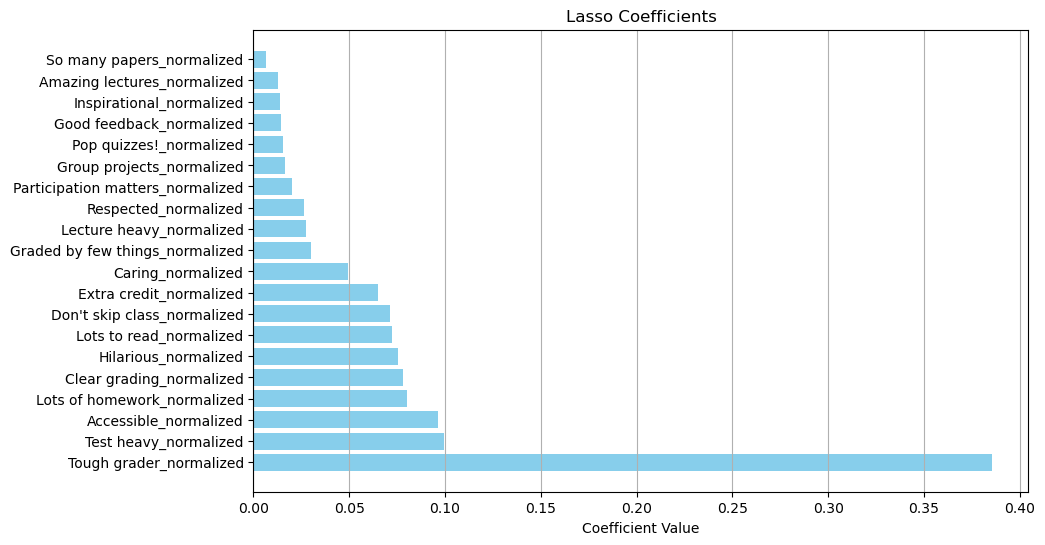

In [22]:
# We use Lasso regression to identify the most important features
# Fit the Lasso model with the best parameters
lasso_best = Lasso(**results['Lasso']['Best_Params'])
lasso_best.fit(X_train_scaled, y_train)

# Extract the coefficients
lasso_coefs = lasso_best.coef_

# Create a DataFrame to display the coefficients
lasso_coefs_df = pd.DataFrame(lasso_coefs, index=feature_columns, columns=['Coefficient'])

# Sort the coefficients by absolute value
lasso_coefs_df['Coefficient_abs'] = np.abs(lasso_coefs_df['Coefficient'])
lasso_coefs_df = lasso_coefs_df.sort_values(by='Coefficient_abs', ascending=False)

# Display the sorted coefficients
print("\nLasso Coefficients (Sorted):")
print(lasso_coefs_df)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(lasso_coefs_df.index, lasso_coefs_df['Coefficient_abs'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients')
plt.grid(axis='x')
plt.show()


### Question 10
Build a classification model that predicts whether a professor receives a “pepper” from all available factors(both tags and numerical). Make sure to include model quality metrics such as AU(RO)C and also address class imbalanceconcerns.

In [16]:
print('before cleaning NA', len(merged_df))
print(merged_df.isnull().sum().sort_values(ascending=False))

before cleaning NA 25368
Proportion Retake                   13208
Average Rating                          0
Inspirational_normalized                0
Extra credit                            0
Group projects                          0
Lecture heavy                           0
Tough grader_normalized                 0
Good feedback_normalized                0
Respected_normalized                    0
Lots to read_normalized                 0
Participation matters_normalized        0
Don't skip class_normalized             0
Lots of homework_normalized             0
Pop quizzes!_normalized                 0
Amazing lectures                        0
Accessible_normalized                   0
So many papers_normalized               0
Clear grading_normalized                0
Hilarious_normalized                    0
Test heavy_normalized                   0
Graded by few things_normalized         0
Amazing lectures_normalized             0
Caring_normalized                       0
Extra cre

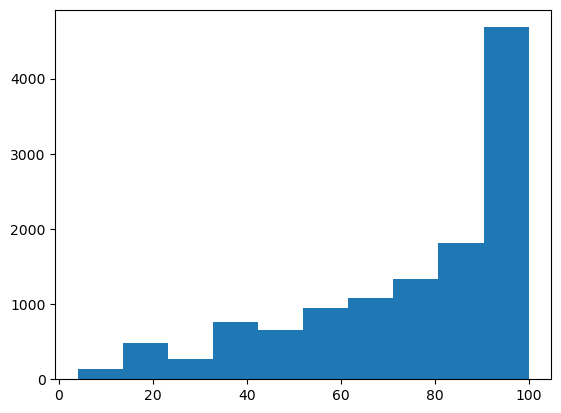

In [17]:
merged_df['Proportion Retake'].describe()
# plot it
plt.hist(merged_df['Proportion Retake'])
plt.show()

In [18]:
merged_df = merged_df.dropna(subset='Proportion Retake')

In [19]:
x_cols = list(set(normalized_columns).union(set(num_columns)))
x_cols.remove("Received a 'pepper'?")
y = merged_df["Received a 'pepper'?"]
X = merged_df[x_cols]

In [20]:
X.head()

,Participation matters_normalized,Don't skip class_normalized,Pop quizzes!_normalized,Accessible_normalized,So many papers_normalized,Inspirational_normalized,Average Difficulty,Lots of homework_normalized,Tough grader_normalized,Respected_normalized,...,Hilarious_normalized,Average Rating,Test heavy_normalized,Graded by few things_normalized,Clear grading_normalized,Group projects_normalized,Female Gender,Number of Ratings,Male Gender,Lots to read_normalized
5,0.090909,0.136364,0.000000,0.136364,0.000000,0.045455,3.3,0.090909,0.363636,0.045455,...,0.136364,3.5,0.000000,0.000000,0.318182,0.045455,0,22.0,1,0.136364
25,0.062500,0.000000,0.062500,0.187500,0.000000,0.437500,3.3,0.000000,0.375000,0.250000,...,0.062500,4.3,0.000000,0.000000,0.000000,0.000000,1,16.0,0,0.062500
40,0.066667,0.266667,0.333333,0.000000,0.000000,0.000000,3.8,0.066667,0.266667,0.000000,...,0.000000,1.8,0.133333,0.066667,0.066667,0.000000,1,15.0,0,0.400000
42,0.047619,0.285714,0.000000,0.000000,0.047619,0.000000,3.3,0.476190,0.238095,0.142857,...,0.047619,4.1,0.000000,0.000000,0.000000,0.095238,1,21.0,0,0.619048
46,0.153846,0.115385,0.000000,0.000000,0.000000,0.269231,1.8,0.115385,0.000000,0.000000,...,0.192308,4.2,0.000000,0.076923,0.230769,0.000000,0,26.0,1,0.269231


In [21]:
# check y class count
y.value_counts()

Received a 'pepper'?
0.0    6494
1.0    5666
Name: count, dtype: int64


Training Logistic Regression...

Training Random Forest...

Training XGBoost...


/opt/anaconda3/envs/NN/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:03:28] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/NN/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:03:28] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/NN/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:03:28] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/NN/lib/python3.12/site-packages/xgboost/core.py

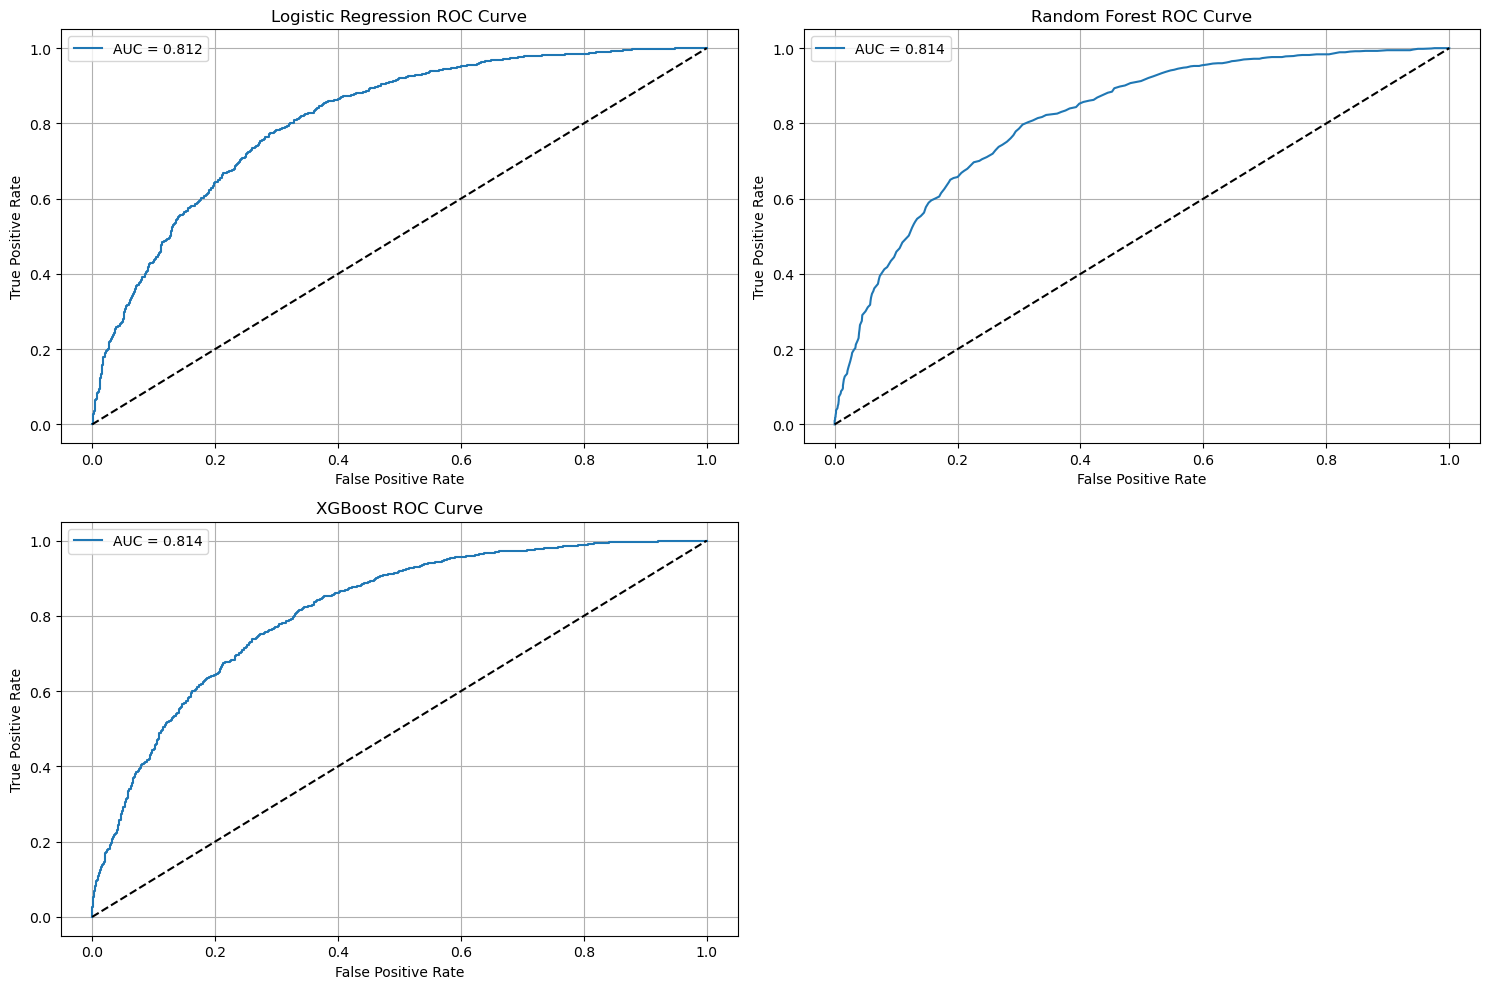

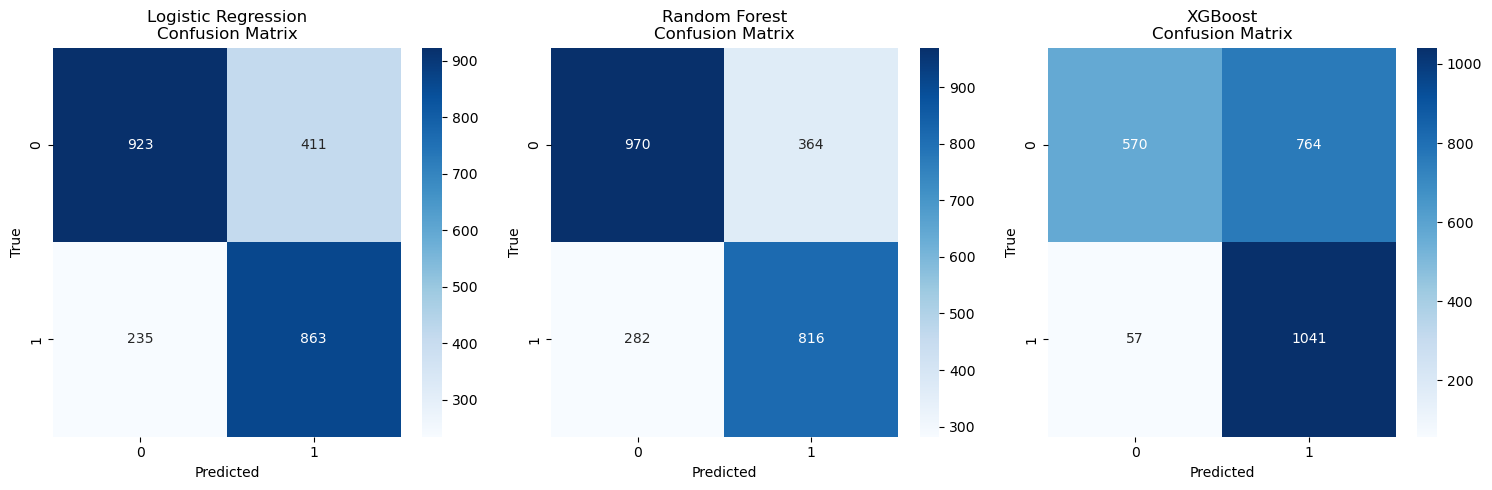

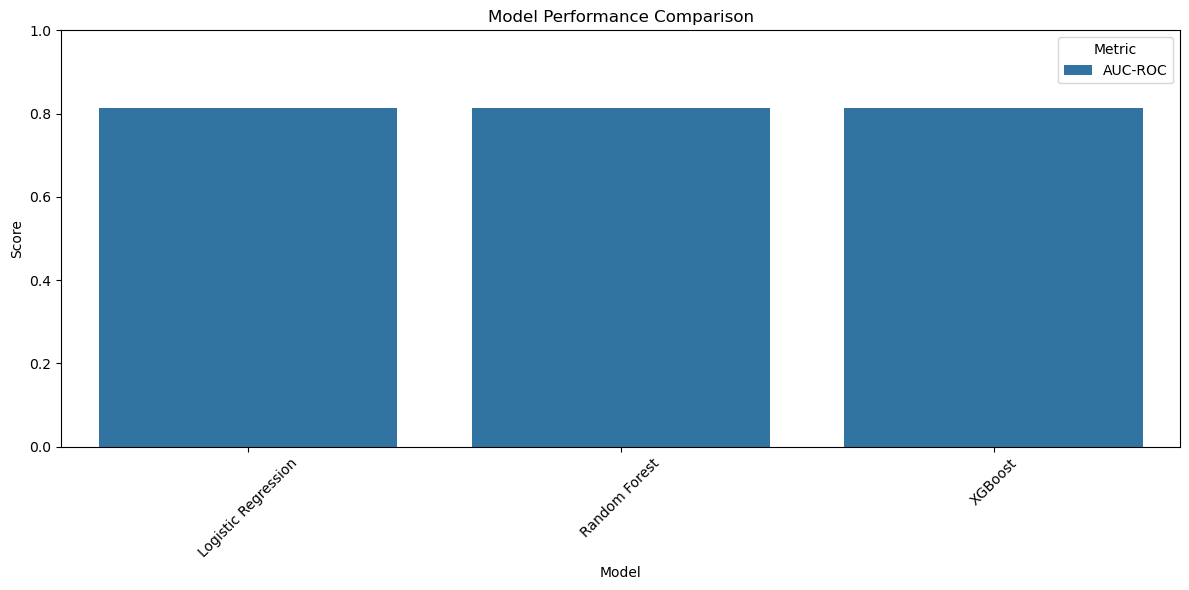


Model Performance Summary:
                     AUC-ROC
XGBoost                0.814
Random Forest          0.814
Logistic Regression    0.812

Best Model (XGBoost) Details:
Best Parameters: {'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 3}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.43      0.58      1334
         1.0       0.58      0.95      0.72      1098

    accuracy                           0.66      2432
   macro avg       0.74      0.69      0.65      2432
weighted avg       0.76      0.66      0.64      2432



In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and apply SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Define expanded set of models with parameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'class_weight': ['balanced', None],
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'class_weight': ['balanced', None]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'scale_pos_weight': [1, 3],
            'class_weight': ['balanced', None]
        }
    },
}

# Train and evaluate models with cross-validation
results = {}
predictions = {}
cv_results = {}  # New dictionary to store cross-validation results
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Define KFold cross-validator

for name, model_info in models.items():
    print(f"\nTraining {name}...")
    
    # Grid search
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    # Fit
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # Perform cross-validation with the best model
    best_model = grid_search.best_estimator_
    cv_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, 
                              cv=kf, scoring='roc_auc', n_jobs=-1)
    
    # Store cross-validation results
    cv_results[name] = {
        'mean_cv_score': cv_scores.mean(),
        'std_cv_score': cv_scores.std(),
        'cv_scores': cv_scores
    }
    
    # Predict
    y_pred_proba = grid_search.predict_proba(X_test_scaled)[:, 1]
    y_pred = grid_search.predict(X_test_scaled)
    
    # Store results
    results[name] = {
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba),
        'Best Params': grid_search.best_params_
    }
    
    predictions[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }



# Plot ROC curves (with multiple subplots for better visibility)
n_cols = 2
n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()

for idx, (name, preds) in enumerate(predictions.items()):
    fpr, tpr, _ = roc_curve(y_test, preds['y_pred_proba'])
    auc = roc_auc_score(y_test, preds['y_pred_proba'])
    
    axes[idx].plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    axes[idx].plot([0, 1], [0, 1], 'k--')
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'{name} ROC Curve')
    axes[idx].legend()
    axes[idx].grid(True)

# Remove empty subplots if any
for idx in range(len(models), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Plot confusion matrices
n_cols = 4
n_rows = (len(models) + 3) // 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.ravel()

for idx, (name, preds) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, preds['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{name}\nConfusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

# Remove empty subplots if any
for idx in range(len(models), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Create performance comparison bar plot
metrics_df = pd.DataFrame(
    [(name, results[name]['AUC-ROC']) 
     for name in results.keys()],
    columns=['Model', 'AUC-ROC']
).melt(id_vars=['Model'], var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Print detailed results
print("\nModel Performance Summary:")
print("=" * 50)
summary_df = pd.DataFrame({
    'AUC-ROC': [results[m]['AUC-ROC'] for m in results],
}, index=results.keys())
summary_df = summary_df.sort_values('AUC-ROC', ascending=False)
print(summary_df.round(3))

# Print detailed results for best model
best_model = summary_df.index[0]
print(f"\nBest Model ({best_model}) Details:")
print("=" * 50)
print(f"Best Parameters: {results[best_model]['Best Params']}")
print("\nClassification Report:")
print(classification_report(y_test, predictions[best_model]['y_pred']))

### Extra Credit
Would major affect the rating of a professor?

Major/Field
Mathematics               1367
English                   1292
Biology                    739
Psychology                 656
Chemistry                  511
                          ... 
Biblical Worldview           1
Mineral Engineering          1
Communication  Culture       1
Logic  Philosophy            1
Apparel Merchandising        1
Name: count, Length: 554, dtype: int64


/var/folders/dv/_l_gwqk95zdggctvnm04j3780000gn/T/ipykernel_34081/4184284490.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(math_rating, label="Mathematics", color='skyblue', shade=True)
/var/folders/dv/_l_gwqk95zdggctvnm04j3780000gn/T/ipykernel_34081/4184284490.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(english_rating, label="English", color='salmon', shade=True)


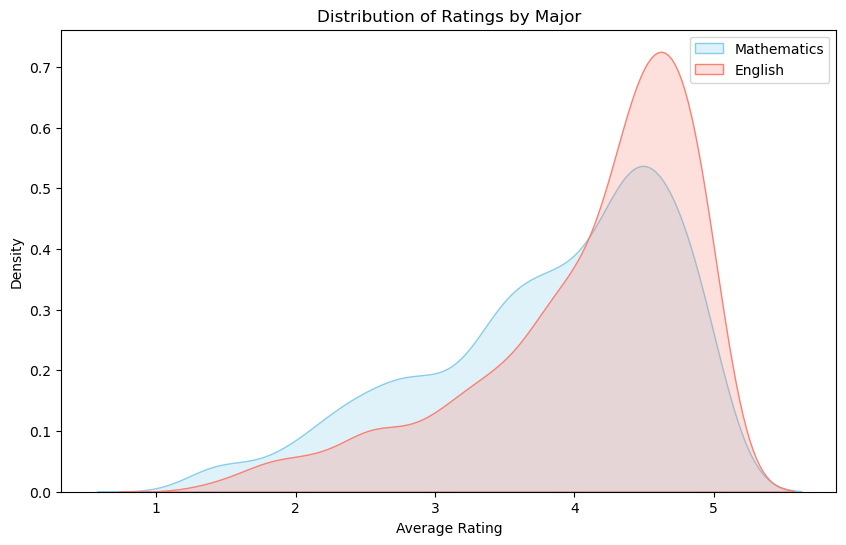

In [27]:
# see the distribution of major
print(merged_df["Major/Field"].value_counts())

math_rating = merged_df[merged_df["Major/Field"] == "Mathematics"]["Average Rating"]
english_rating = merged_df[merged_df["Major/Field"] == "English"]["Average Rating"]

plt.figure(figsize=(10, 6))
sns.kdeplot(math_rating, label="Mathematics", color='skyblue', shade=True)
sns.kdeplot(english_rating, label="English", color='salmon', shade=True)
plt.xlabel("Average Rating")
plt.ylabel("Density")
plt.title("Distribution of Ratings by Major")
plt.legend()
plt.show()


In [28]:
# Perform the Kolmogorov-Smirnov test
ks_stat, p_value = ks_2samp(math_rating, english_rating)
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Perform the Mann-Whitney U test
u_stat, p_value = mannwhitneyu(math_rating, english_rating)
print(f"U Statistic: {u_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

KS Statistic: 0.1538
P-Value: 0.0000
U Statistic: 710200.0000
P-Value: 0.0000
